In [1]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import mannwhitneyu
from scipy import stats
import datetime

### Bir market zinciri, müşterilerinin satın aldıkları ürünlerin verilerini toplayarak bir veri seti oluşturmak istiyor. Veri seti, müşterilerin isimleri, yaşları, cinsiyetleri, satın aldıkları ürünlerin isimleri, fiyatları ve tarihleri gibi bilgileri içerecek.

In [2]:
data = {'Müşteri Adı': ['Ali', 'Ayşe', 'Fatma', 'Mehmet', 'Cem', 'Ece', 'Ahmet', 'Zeynep', 'Deniz', 'Ebru'],
        'Yaş': [28, 42, 34, 19, 25, 37, 47, 30, 24, 31],
        'Cinsiyet': ['Erkek', 'Kadın', 'Kadın', 'Erkek', 'Erkek', 'Kadın', 'Erkek', 'Kadın', 'Erkek', 'Kadın'],
        'Ürün Adı': ['Süt', 'Ekmek', 'Peynir', 'Yoğurt', 'Ayran', 'Ekmek', 'Süt', 'Peynir', 'Ayran', 'Yoğurt'],
        'Fiyat': [2.50, 1.50, 5.00, 1.75, 2.00, 1.50, 2.50, 4.00, 2.00, 1.75],
        'Tarih': ['2022-04-01', '2022-04-01', '2022-04-02', '2022-04-03', '2022-04-03', '2022-04-04', '2022-04-04', '2022-04-05', '2022-04-06', '2022-04-06']}

df = pd.DataFrame(data)
df.head()

,Müşteri Adı,Yaş,Cinsiyet,Ürün Adı,Fiyat,Tarih
0,Ali,28,Erkek,Süt,2.50,2022-04-01
1,Ayşe,42,Kadın,Ekmek,1.50,2022-04-01
2,Fatma,34,Kadın,Peynir,5.00,2022-04-02
3,Mehmet,19,Erkek,Yoğurt,1.75,2022-04-03
4,Cem,25,Erkek,Ayran,2.00,2022-04-03


# Veri Analizi

In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Yaş,10.0,31.70,8.538150,19.0,25.75,30.5,36.25,47.0
Fiyat,10.0,2.45,1.159502,1.5,1.75,2.0,2.50,5.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Müşteri Adı  10 non-null     object 
 1   Yaş          10 non-null     int64  
 2   Cinsiyet     10 non-null     object 
 3   Ürün Adı     10 non-null     object 
 4   Fiyat        10 non-null     float64
 5   Tarih        10 non-null     object 
dtypes: float64(1), int64(1), object(4)
memory usage: 608.0+ bytes


In [5]:
df.var()

C:\Users\murat\AppData\Local\Temp\ipykernel_10072\1568254755.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.var()


Yaş      72.900000
Fiyat     1.344444
dtype: float64

In [6]:
df.corr()

,Yaş,Fiyat
Yaş,1.000000,0.054433
Fiyat,0.054433,1.000000


# Veri Ön İşleme

In [7]:
# eksik değer analizi yapalım.
df.isnull().sum()

Müşteri Adı    0
Yaş            0
Cinsiyet       0
Ürün Adı       0
Fiyat          0
Tarih          0
dtype: int64

In [8]:
# tekrar eden gözlemleri inceleyelim.
df.duplicated().sum()

0

In [9]:
# Kategorik değişkenleri sayısal değişkenlere dönüştürelim.
df['Cinsiyet'] = pd.factorize(df['Cinsiyet'])[0] # 0:erkek, 1:kadın
df['Ürün Adı'] = pd.factorize(df['Ürün Adı'])[0] # 0: Süt, 1: Ekmek, 2: Peynir, 3:Yoğurt, 4:Ayran


### Tarih değişkenini modelin kabul edebileceği bir düzene getirmemiz gerekiyor. Bunun için, tarihleri öncelikle sayısal verilere dönüştürmemiz gerekir. Bu amaçla, tarihi örneğin Unix zaman damgası gibi bir zaman damgası biçiminde ifade edebiliriz. Unix zaman damgası, 1970 yılından beri geçen saniye sayısını temsil eder.

In [10]:
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in df['Tarih']]

# Unix zaman damgası biçiminde tarihleri dönüştürelim.
unix_times = [int(date.timestamp()) for date in dates]

# başvuru tarihi belirleme
reference_time = unix_times[0]

# tarihler arasındaki farkları hesaplama
time_diffs = [time - reference_time for time in unix_times]

df['Tarih'] = time_diffs

In [11]:
df.head()

,Müşteri Adı,Yaş,Cinsiyet,Ürün Adı,Fiyat,Tarih
0,Ali,28,0,0,2.50,0
1,Ayşe,42,1,1,1.50,0
2,Fatma,34,1,2,5.00,86400
3,Mehmet,19,0,3,1.75,172800
4,Cem,25,0,4,2.00,172800


# Hipotez Testleri

### Satın alınan ürünlerin fiyatları, cinsiyetine göre farklılık gösterir mi ?

## Hipotezlerimiz:

### H0: Erkek ve kadın müşterilerin satın aldıkları ürünlerin fiyatları arasında fark yoktur.
### H1: Erkek ve kadın müşterilerin satın aldıkları ürünlerin fiyatları arasında fark vardır.

In [12]:
# örneklemlerimizi oluşturalım.

# erkek müşterilerin fiyat ortalaması
erkek_fiyat = df[df['Cinsiyet'] == 0]['Fiyat']
erkek_mean = erkek_fiyat.mean()

# kadın müşterilerin fiyat ortalaması
kadin_fiyat = df[df['Cinsiyet'] == 1]['Fiyat']
kadin_mean = kadin_fiyat.mean()

### Şimdi ise hangi hipotez testini uygulayacağımızı varsayımlar üzerinden bulalım.

# Normallik Varsayımı: Örneklemler normal dağılıyor mu ?

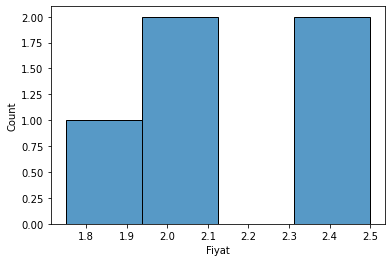

In [13]:
sns.histplot(data=erkek_fiyat);

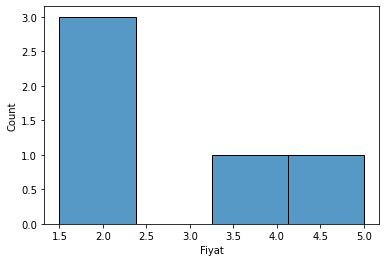

In [14]:
sns.histplot(data=kadin_fiyat);

### Örneklemler normal dağılmıyor. Şimdi ise varyans homojenliği varsayımını inceleyelim. Bu varsayıma göre iki örneklemin varyanslarının birbirine eşit olması gerekmektedir.

In [15]:
erkek_fiyat.var()

0.11249999999999999

In [16]:
kadin_fiyat.var()

2.6875

### Varyanslar birbirine eşit olmadığı için varyans varsayımını sağlayamadık.

### Bir diğer varsayım ise bağımsız örneklem varsayımıdır. Bu varsayım, iki örneklemin birbirinden farklı olması gerektiğini varsayar. Bu senaryoda, iki örneklem birbirinden farklıdır.

# **************************

### Sonuç olarak, örneklemler normal dağılmadığı ve varyansları birbirlerine eşit olmadı için non-parametrik hipotez testi yapacağız. Man Whitney U testi yapabiliriz.

In [17]:
t_stat, p_value = mannwhitneyu(erkek_fiyat, kadin_fiyat)
print('Test İstatistiği: ', t_stat)
print('P-Value: ', p_value)
print('##################################################')

alpha = 0.05
if p_value < alpha:
    print('H0 reddedildi. Erkek ve kadın müşterilerin satın aldıkları ürünlerin fiyatları arasında fark vardır')
else:
    print('H0 reddedilmedi. Erkek ve kadın müşterilerin satın aldıkların ürünlerin fiyatları arasında fark yoktur.')

Test İstatistiği:  14.5
P-Value:  0.7510855375484595
##################################################
H0 reddedilmedi. Erkek ve kadın müşterilerin satın aldıkların ürünlerin fiyatları arasında fark yoktur.


# ----------------------------------------------

# Model İşlemleri

In [18]:
# bağımlı ve bağımsız değişkenleri oluşturalım.
X = df.drop(['Fiyat', 'Müşteri Adı'], axis=1)
y = df['Fiyat']

In [19]:
# eğitim ve test setlerini ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# modeli oluşturalım ve eğitelim.
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

In [21]:
# Test seti üzerinde tahmin yapalım.
y_pred = knn.predict(X_test)

In [22]:
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('R-Kare Değeri: ', r2)
print('Ortalama Kare Hata Değeri: ', mse)

R-Kare Değeri:  -8.799999999999997
Ortalama Kare Hata Değeri:  0.6124999999999998


# Model Tuning Ve Model Doğrulama İşlemleri

In [26]:
from sklearn.model_selection import GridSearchCV
params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute']
}
grid_knn = GridSearchCV(estimator=knn, param_grid=params, cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)

print('En iyi parametreler: ', grid_knn.best_params_)

En iyi parametreler:  {'algorithm': 'ball_tree', 'n_neighbors': 3, 'weights': 'uniform'}


C:\Users\murat\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan]
  warnings.warn(


### En iyi parametreler için modelimizi tekrar kuralım.

In [28]:
knn = KNeighborsRegressor(n_neighbors=3, algorithm='ball_tree', weights='uniform').fit(X_train, y_train)

In [29]:
y_pred = knn.predict(X_test)

In [30]:
r2 = r2_score(y_test, y_pred)
print('R-Kare: ', r2)

R-Kare:  -22.611111111111107


# Model Doğrulama İşlemi

In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(grid_knn.best_estimator_, X, y, cv=5, scoring='neg_root_mean_squared_error')
print('K-NN regresyon modeli için RMSE: ', -scores.mean())

K-NN regresyon modeli için RMSE:  1.364200271849721


# Sonuç

### Üzerinde çalıştığımız veri seti yapay olduğu için gerçek hayat senaryosunu temsil etmez. Amacımız, nasıl adım atmamız gerektiğini anlamak ve kullandığımız teknolojileri pratik etmektir.